# Protocolo para descarga, actualizacion y extraccion de estadisticas de los datos satelitales ERA5 para la Estacion Tiputini USFQ

### 1. Descarga de datos. Para la descarga de datos se utiliza la siguiente linea de codigo, en donde se requiere que el usuario tenga el archivo .cdsapirc en el $HOME directory , o la carpeta del usuario (e.g: /Users/manuelnarvaez/), el cual debe contener estas dos lineas dentro: 
#### url: https://cds.climate.copernicus.eu/api/v2
#### key: 262290:b6d6a2a2-5d02-4793-84cd-dc7c1564b5cc 
##### El key number variara dependiendo de la cuenta que se este utilizando para bajar los datos

#### Una vez obtenido estos datos se debe tener instalado python y era5cli para la descarga, y solo una vez se debe escribir en una terminal vacia esta linea de codigo: era5cli config --uid ID_NUMBER --key "KEY" en donde ID_NUMBER es el numero de usuario asignado en la pagina web y KEY es el key number previamente copiado en el documento .cdsapirc

### Para poder realizar este primer paso se debe registrar una cuenta en https://cds.climate.copernicus.eu, este proceso genera un key number y un nombre de usuario.

### Debido a que el codigo esta en formato semi-cajanegra se debe asegurar que se corra el documento en una computadora con los pasos previamente explicados, y con suficiente espacio (1mes~1GB, 10años~20GB) y tiempo para la descarga total.


In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import subprocess

# Define your variables list, years, and months
variables_list = [
    '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
    '2m_temperature', 'evaporation_from_bare_soil', 'evaporation_from_open_water_surfaces_excluding_oceans',
    'evaporation_from_the_top_of_canopy', 'evaporation_from_vegetation_transpiration', 'forecast_albedo',
    'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation', 'potential_evaporation',
    'runoff', 'skin_reservoir_content', 'skin_temperature',
    'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3',
    'soil_temperature_level_4', 'sub_surface_runoff', 'surface_latent_heat_flux',
    'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_pressure',
    'surface_runoff', 'surface_sensible_heat_flux', 'surface_solar_radiation_downwards',
    'surface_thermal_radiation_downwards', 'total_evaporation', 'total_precipitation',
    'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3',
    'volumetric_soil_water_layer_4'
]

years = [str(year) for year in range(1979, 2030 + 1)]
months = [f"{month:02d}" for month in range(1, 12 + 1)]

# Initialize the main application window
root = tk.Tk()
root.title("ERA5 Data Download Configuration")

# Create BooleanVar objects for each month after initializing the main window
month_selections = [tk.BooleanVar(value=False) for _ in months]

def download_selected_variables(var_indices, start_year, end_year, month_indices):
    """Download selected variables by opening a new terminal for each."""
    months_selected = [months[i] for i, selected in enumerate(month_selections) if selected.get()]
    months_str = " ".join(months_selected)
    
    for index in var_indices:
        variable = variables_list[index]
        command = (
            f"era5cli hourly --land --variables {variable} "
            f"--startyear {start_year} "
        )
        
        if months_selected:
            command += f"--months {months_str} --splitmonths True --area 1.5 -79 -2 -74.5"  # Change area if needed
        else:
            command += f"--endyear {end_year} --splitmonths True --area 1.5 -79 -2 -74.5"  # Change area if needed

        osascript_command = f"""osascript -e 'tell app "Terminal" to do script "{command}"'"""
        subprocess.run(osascript_command, shell=True, check=True)
       

def on_submit():
    selected_var_indices = list(map(int, listbox_vars.curselection()))
    month_indices = [i for i, selected in enumerate(month_selections) if selected.get()]
    start_year = combo_start_year.get()
    end_year = combo_end_year.get()
    
    if not selected_var_indices:
        messagebox.showinfo("No variable selected", "Please select at least one variable to download.")
        return
    
    if not start_year:
        messagebox.showinfo("Year selection", "Please select a start year.")
        return
    
    download_selected_variables(selected_var_indices, start_year, end_year, month_indices)

# Variables selection
tk.Label(root, text="Select Variables:").pack()
listbox_vars = tk.Listbox(root, selectmode=tk.MULTIPLE, width=50, height=10)
for variable in variables_list:
    listbox_vars.insert(tk.END, variable)
listbox_vars.pack()

# Year selection
tk.Label(root, text="Select Start Year:").pack()
combo_start_year = ttk.Combobox(root, values=years, state="readonly")
combo_start_year.pack()

tk.Label(root, text="Select End Year:").pack()
combo_end_year = ttk.Combobox(root, values=years, state="readonly")
combo_end_year.pack()

# Months selection using Checkbuttons
month_frame = tk.Frame(root)
tk.Label(month_frame, text="Select Months:").pack()
for i, month in enumerate(months):
    tk.Checkbutton(month_frame, text=month, variable=month_selections[i]).pack(anchor=tk.W)
month_frame.pack()

# Submit button
submit_btn = tk.Button(root, text="Download Selected Data", command=on_submit)
submit_btn.pack()

# Start the Tkinter event
root.mainloop()


tab 1 of window id 1873


In [1]:
import netCDF4 as nc
import numpy as np
import os

def check_longitude_range(nc_file_path):
    """
    Check the maximum and minimum longitudes of a NetCDF file.
    
    Parameters:
    nc_file_path (str): Path to the NetCDF file.
    
    Returns:
    tuple: (min_longitude, max_longitude) or 'Unknown format' if longitude variable not found.
    """
    try:
        dataset = nc.Dataset(nc_file_path, 'r')
        if 'lon' in dataset.variables:
            longitudes = dataset.variables['lon'][:]
        elif 'longitude' in dataset.variables:
            longitudes = dataset.variables['longitude'][:]
        else:
            return 'Unknown format'
        
        min_longitude = np.min(longitudes)
        max_longitude = np.max(longitudes)
        return (min_longitude, max_longitude)
    except Exception as e:
        return f'Error: {e}'

def check_longitudes_in_directory(directory_path):
    """
    Check the longitude ranges of all NetCDF files in a directory.
    
    Parameters:
    directory_path (str): Path to the directory containing NetCDF files.
    
    Returns:
    dict: A dictionary with filenames as keys and longitude ranges (min, max) as values.
    """
    results = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.nc'):
            file_path = os.path.join(directory_path, filename)
            range_result = check_longitude_range(file_path)
            results[filename] = range_result
    return results

def print_sorted_results(results):
    """
    Print the results sorted by file name.
    
    Parameters:
    results (dict): A dictionary with filenames as keys and longitude ranges (min, max) as values.
    """
    for filename in sorted(results.keys()):
        print(f'{filename}: {results[filename]}')
        
# Example usage
directory_path = '/Users/manuelnarvaez/Original_Evapo/' ## Include the folder where the data is downloaded
results = check_longitudes_in_directory(directory_path)
print_sorted_results(results)



era5-land_evaporation_from_bare_soil_1979-01_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-02_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-03_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-04_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-05_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-06_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-07_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-08_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-09_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-10_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-11_hourly_79W-74W_2S-2N.nc: (281.0, 285.5)
era5-land_evaporation_from_bare_soil_1979-12_hourly_79W-74W_2S-2N

In [ ]:
import tkinter as tk
from tkinter import filedialog, Listbox, MULTIPLE, messagebox
import os
import xarray as xr
import numpy as np

# Variables list for longitude correction
variables_list = [
    'evaporation_from_bare_soil', 'evaporation_from_open_water_surfaces_excluding_oceans',
    'evaporation_from_the_top_of_canopy', 'evaporation_from_vegetation_transpiration'
]

def select_directory(title="Select Directory"):
    """Open a dialog to select a directory."""
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    directory_path = filedialog.askdirectory(title=title)
    return directory_path

def create_save_directory(original_directory):
    """
    Create a new directory inside the original directory for saving the updated files.
    
    Parameters:
    - original_directory: Directory containing the original NetCDF files.
    
    Returns:
    - new_dir_path: Path to the new directory for saving updated files.
    """
    new_dir_path = os.path.join(original_directory, "corrected_files")
    os.makedirs(new_dir_path, exist_ok=True)
    return new_dir_path

def correct_longitudes_and_save(files_directory, save_directory, variables_to_update):
    """
    Corrects longitudes for selected variables and saves the corrected data to a new directory.
    
    Parameters:
    - files_directory: Directory containing the original NetCDF files.
    - save_directory: Directory to save the corrected NetCDF files.
    - variables_to_update: List of variables selected for longitude correction.
    """
    for variable in variables_to_update:
        for file in os.listdir(files_directory):
            if variable in file and file.endswith('.nc'):
                file_path = os.path.join(files_directory, file)
                ds = xr.open_dataset(file_path)
                
                # Correct longitude values
                if 'longitude' in ds.coords:
                    ds.coords['longitude'] = ds.coords['longitude'] - 360
                    ds.coords['longitude'] = ds.coords['longitude'].round(decimals=1)

                # Save the corrected dataset to the new directory
                file_path_updated = os.path.join(save_directory, file)
                ds.to_netcdf(file_path_updated)
                print(f"Corrected data saved to {file_path_updated}")
                
                ds.close()

def on_submit(variables_selected):
    original_directory = select_directory(title="Select Directory Containing NetCDF Files")
    if not original_directory:
        messagebox.showinfo("No directory selected", "Please select a valid directory containing NetCDF files.")
        return
    
    save_directory = create_save_directory(original_directory)
    
    correct_longitudes_and_save(original_directory, save_directory, variables_selected)

if __name__ == "__main__":
    # Setup the GUI for variable selection
    root = tk.Tk()
    root.title("Select Variables for Longitude Correction")

    tk.Label(root, text="Select Variables:").pack()
    listbox = Listbox(root, selectmode=MULTIPLE, width=50, height=len(variables_list))
    for variable in variables_list:
        listbox.insert(tk.END, variable)
    listbox.pack()

    submit_btn = tk.Button(root, text="Correct Longitudes and Save", command=lambda: on_submit([variables_list[int(i)] for i in listbox.curselection()]))
    submit_btn.pack()

    root.mainloop()


In [1]:
import tkinter as tk
from tkinter import filedialog
import xarray as xr
import os
import glob
import dask

def select_netcdf_folder():
    """Open a dialog to select a folder containing NetCDF files."""
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    folder_path = filedialog.askdirectory(
        title='Select Folder Containing NetCDF Files'
    )
    return folder_path

def select_large_netcdf_file():
    """Open a dialog to select the large NetCDF file to be updated."""
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(
        title='Select the large NetCDF file',
        filetypes=[('NetCDF files', '*.nc')]
    )
    return file_path

def merge_netcdf_files(large_file_path, netcdf_folder):
    """Merge NetCDF files from a folder with the existing large NetCDF file."""
    # Find all NetCDF files in the selected folder
    new_files = glob.glob(os.path.join(netcdf_folder, '*.nc'))
    
    if not new_files:
        print("No NetCDF files were found in the selected folder.")
        return
    
    # Load the large NetCDF file with Dask
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        large_ds = xr.open_dataset(large_file_path, engine='netcdf4', chunks={'time': 1000})
    
    print('large_ds_read')
    # Load each new NetCDF file with Dask
    new_ds = xr.open_mfdataset(new_files, engine='netcdf4', combine='by_coords', chunks={'time': 1000})
    print(new_files)
    # Merge the new data with the large dataset
    large_ds = xr.merge([large_ds, new_ds], combine_attrs='override')
    print('large_ds_merge')
    # Save the updated dataset back to the large NetCDF file or a new file if preferred
    updated_file_path = os.path.splitext(large_file_path)[0] + '_updated.nc'
    encoding = {var: {'zlib': True, 'complevel': 9} for var in large_ds.data_vars}
    large_ds.to_netcdf(updated_file_path)
    print(f"Updated dataset saved to {updated_file_path}")

# Example usage
if __name__ == "__main__":
    print("Select the large NetCDF file to be updated:")
    large_file_path = select_large_netcdf_file()
    if large_file_path:
        print("Select the folder containing the new NetCDF files:")
        netcdf_folder = select_netcdf_folder()
        if netcdf_folder:
            merge_netcdf_files(large_file_path, netcdf_folder)
        else:
            print("No folder was selected.")
    else:
        print("No large NetCDF file was selected.")


Select the large NetCDF file to be updated:
Select the folder containing the new NetCDF files:
large_ds_read
['/Users/manuelnarvaez/Documents/NewData/era5-land_2m_temperature_2024-03_hourly_79W-74W_2S-2N.nc', '/Users/manuelnarvaez/Documents/NewData/era5-land_2m_temperature_2024-01_hourly_79W-74W_2S-2N.nc', '/Users/manuelnarvaez/Documents/NewData/era5-land_2m_temperature_2024-02_hourly_79W-74W_2S-2N.nc']


/Users/manuelnarvaez/anaconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


large_ds_merge
Updated dataset saved to /Users/manuelnarvaez/Documents/ncfile_complete_updated.nc


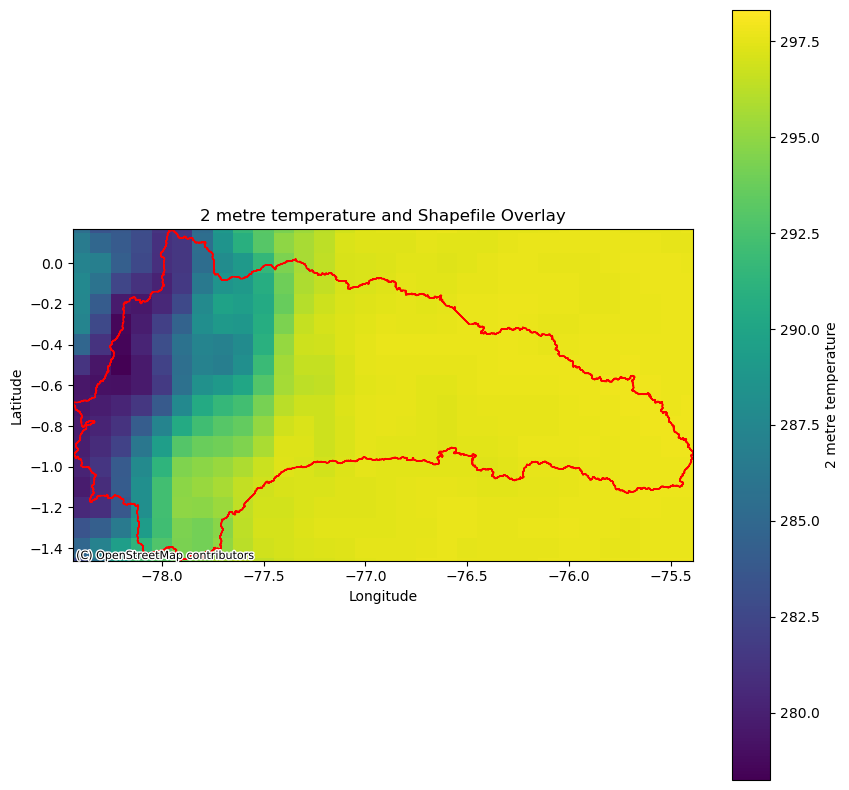

/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_12677/2601993818.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = shp.geometry.centroid.iloc[0]


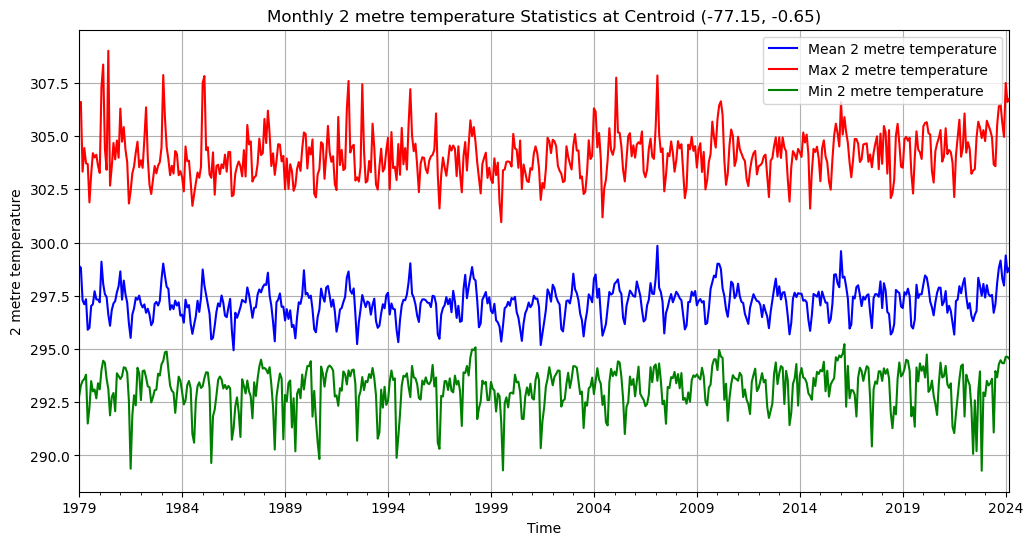

Monthly statistics saved to monthly_t2m_statistics.csv


In [3]:
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import xarray as xr
import pandas as pd

def select_file(title, filetypes):
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title, filetypes=filetypes)
    return file_path

def select_variable(ds):
    variable_options = [f"{var} ({ds[var].attrs.get('long_name', 'No long name')})" for var in ds.variables]
    variable_selection = simpledialog.askstring("Input", f"Available variables:\n" + "\n".join(variable_options) + "\n\nPlease enter the variable name to use:")
    variable = variable_selection.split()[0]  # Extract the variable name
    return variable

def get_conversion(variable):
    kelvin_vars = ['d2m', 't2m', 'stl1', 'stl2', 'stl3', 'stl4', 'skt']
    meter_vars = ['tp', 'e', 'evabs', 'evaow', 'evatc', 'evavt', 'pev', 'ro', 'sro', 'src', 'ssro']

    if variable in kelvin_vars:
        conversion = simpledialog.askstring("Conversion", "Convert from Kelvins to:\n1. Celsius\n2. Fahrenheit")
        if conversion == '1':
            return lambda x: x - 273.15, 'Celsius'
        elif conversion == '2':
            return lambda x: (x - 273.15) * 9/5 + 32, 'Fahrenheit'
        else:
            return None, 'Kelvins'
    elif variable in meter_vars:
        conversion = simpledialog.askstring("Conversion", "Convert from Meters to:\n1. Millimeters\n2. Inches")
        if conversion == '1':
            return lambda x: x * 1000, 'Millimeters'
        elif conversion == '2':
            return lambda x: x * 39.3701, 'Inches'
        else:
            return None, 'Meters'
    else:
        return None, None

def load_and_plot_data_with_pcolormesh(shapefile_path, netcdf_path, variable):
    # Load the NetCDF data
    ds = xr.open_dataset(netcdf_path)
    
    # Select the specified variable
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the NetCDF file.")
    data = ds[variable]
    units=ds[variable].units
    # Get the long name of the variable
    long_name = data.attrs.get('long_name', variable)
    
    # For simplicity, select the first time step if the variable has a time dimension
    if 'time' in ds.dims:
        data = data.mean(dim='time')
    
    # Ensure the data is in 2D (latitude x longitude)
    assert data.ndim == 2, "Data must be 2D (latitude x longitude)."
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the NetCDF data using pcolormesh
    # Note: We assume the latitude and longitude are 1D arrays. Adjust as necessary.
    temperature = data.values
    lon = data.longitude.values
    lat = data.latitude.values
    mesh = ax.pcolormesh(lon, lat, temperature, shading='auto', cmap='viridis')
    fig.colorbar(mesh, ax=ax, label=long_name)
    
    # Load and plot the shapefile on top
    shp = gpd.read_file(shapefile_path)
    if shp.crs.to_string() != 'epsg:4326':
        shp = shp.to_crs(epsg=4326)
    shp.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
    
    # Add a basemap
    try:
        # Set the extent of the plot to the bounds of the shapefile
        minx, miny, maxx, maxy = shp.total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    except Exception as e:
        print(f"Contextily basemap could not be added. Error: {e}")

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{long_name} and Shapefile Overlay')
    plt.show()
    
    return shp, ds, long_name, data, units

def plot_and_save_statistics(shp, ds, variable, long_name, units, conversion_func=None, new_units=None):
    # Ensure original units are preserved if no conversion is applied
    original_units = units
    effective_units = new_units if new_units else original_units
    
    # Iterate through each geometry in the shapefile
    for idx, geometry in enumerate(shp.geometry):
        centroid = geometry.centroid
        lon, lat = centroid.x, centroid.y
        
        # Extract the time series at the centroid
        ts = ds[variable].sel(longitude=lon, latitude=lat, method='nearest')
        
        # Apply conversion if necessary
        if conversion_func:
            ts.values = conversion_func(ts.values)
        
        # Convert to a pandas DataFrame
        ts_df = ts.to_dataframe().reset_index()
        ts_df.set_index('time', inplace=True)
        
        # Resample to different frequencies and calculate statistics
        stats = {
            'monthly': ts_df.resample('M').agg(['mean', 'max', 'min']),
            'weekly': ts_df.resample('W').agg(['mean', 'max', 'min']),
            'hourly': ts_df.resample('H').agg(['mean', 'max', 'min']),
            'annually': ts_df.resample('A').agg(['mean', 'max', 'min'])
        }
        
        # Plotting the statistics
        fig, axs = plt.subplots(4, 1, figsize=(12, 24))
        
        for ax, (freq, df) in zip(axs, stats.items()):
            df[variable]['mean'].plot(ax=ax, label=f'Mean {long_name}', color='blue')
            df[variable]['max'].plot(ax=ax, label=f'Max {long_name}', color='red')
            df[variable]['min'].plot(ax=ax, label=f'Min {long_name}', color='green')
            ax.set_title(f'{freq.capitalize()} {long_name} Statistics at Point {idx + 1} ({lon:.2f}, {lat:.2f})')
            ax.set_xlabel('Time')
            ax.set_ylabel(effective_units)
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'statistics_{variable}_point_{idx + 1}.png')
        plt.show()

        # Save the statistics to CSV files with units
        for freq, df in stats.items():
            df['units'] = effective_units
            csv_filename = f'{freq}_{variable}_statistics_point_{idx + 1}.csv'
            df.to_csv(csv_filename)
            print(f"{freq.capitalize()} statistics saved to {csv_filename}")

# Example usage
shapefile_path = select_file("Select a Shapefile", [("Shapefiles", "*.shp")])
netcdf_path = select_file("Select a NetCDF File", [("NetCDF files", "*")])

if shapefile_path and netcdf_path:
    ds = xr.open_dataset(netcdf_path)
    variable = select_variable(ds)
    conversion_func, new_units = get_conversion(variable)
    shp, ds, long_name, data, units = load_and_plot_data_with_pcolormesh(shapefile_path, netcdf_path, variable)
    plot_and_save_statistics(shp, ds, variable, long_name, units, conversion_func, new_units)
else:
    print("Necessary files not selected.")



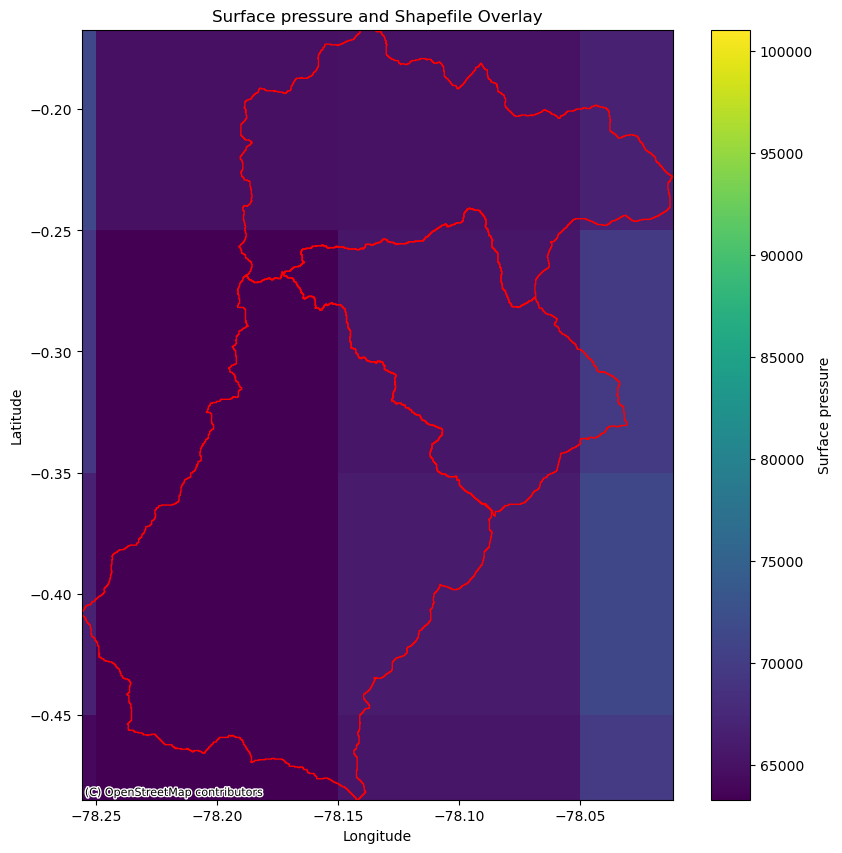

/Users/manuelnarvaez/anaconda3/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


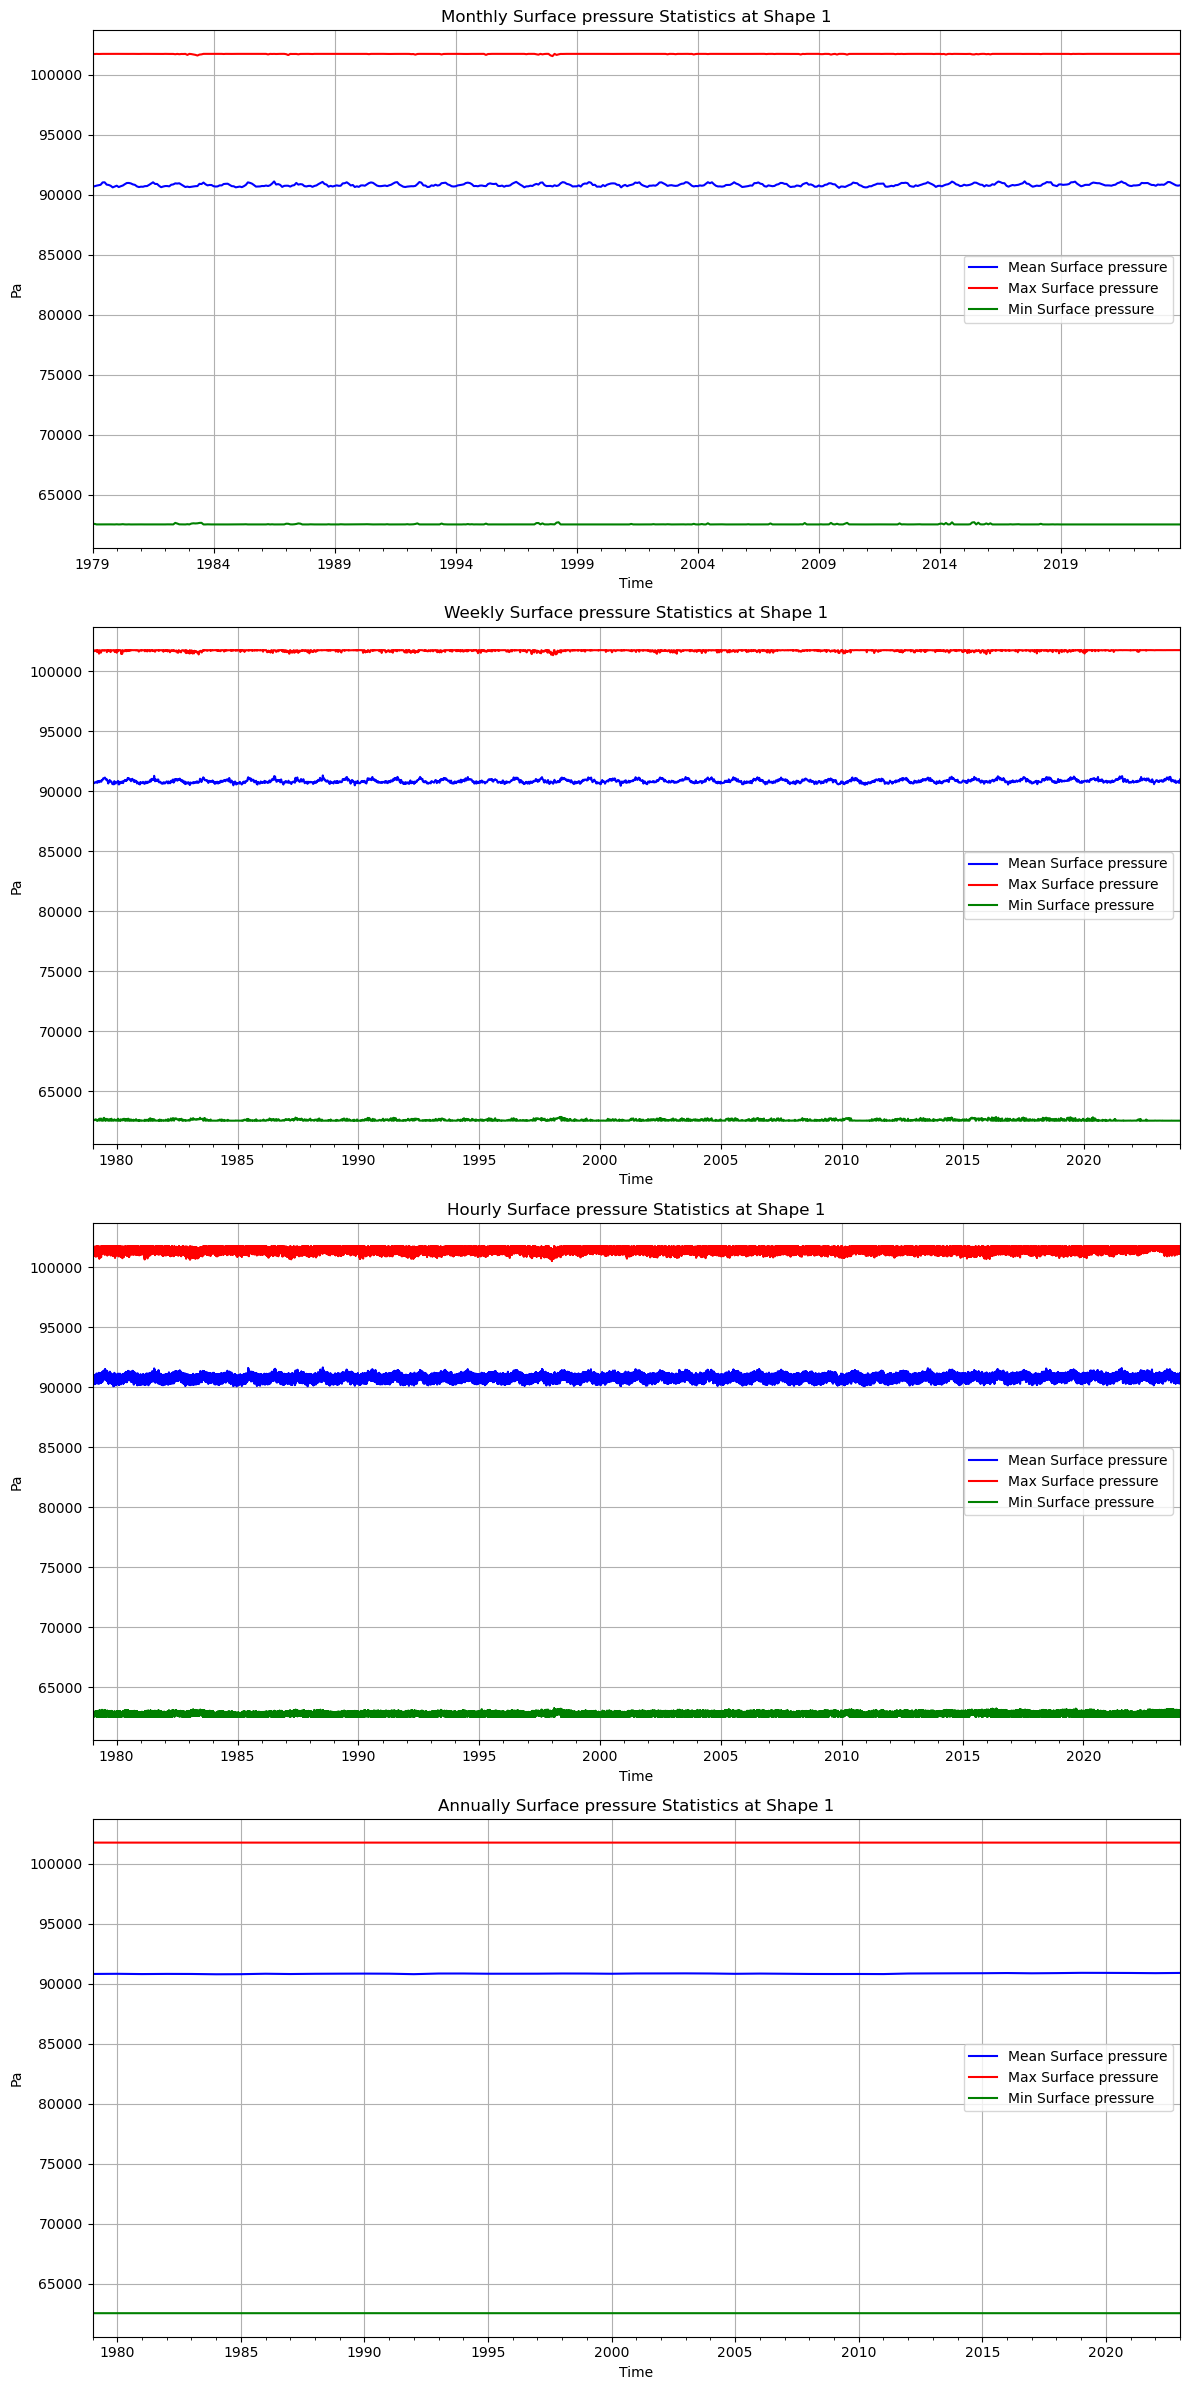

Monthly statistics saved to monthly_sp_statistics_shape_1.csv
Weekly statistics saved to weekly_sp_statistics_shape_1.csv
Hourly statistics saved to hourly_sp_statistics_shape_1.csv
Annually statistics saved to annually_sp_statistics_shape_1.csv


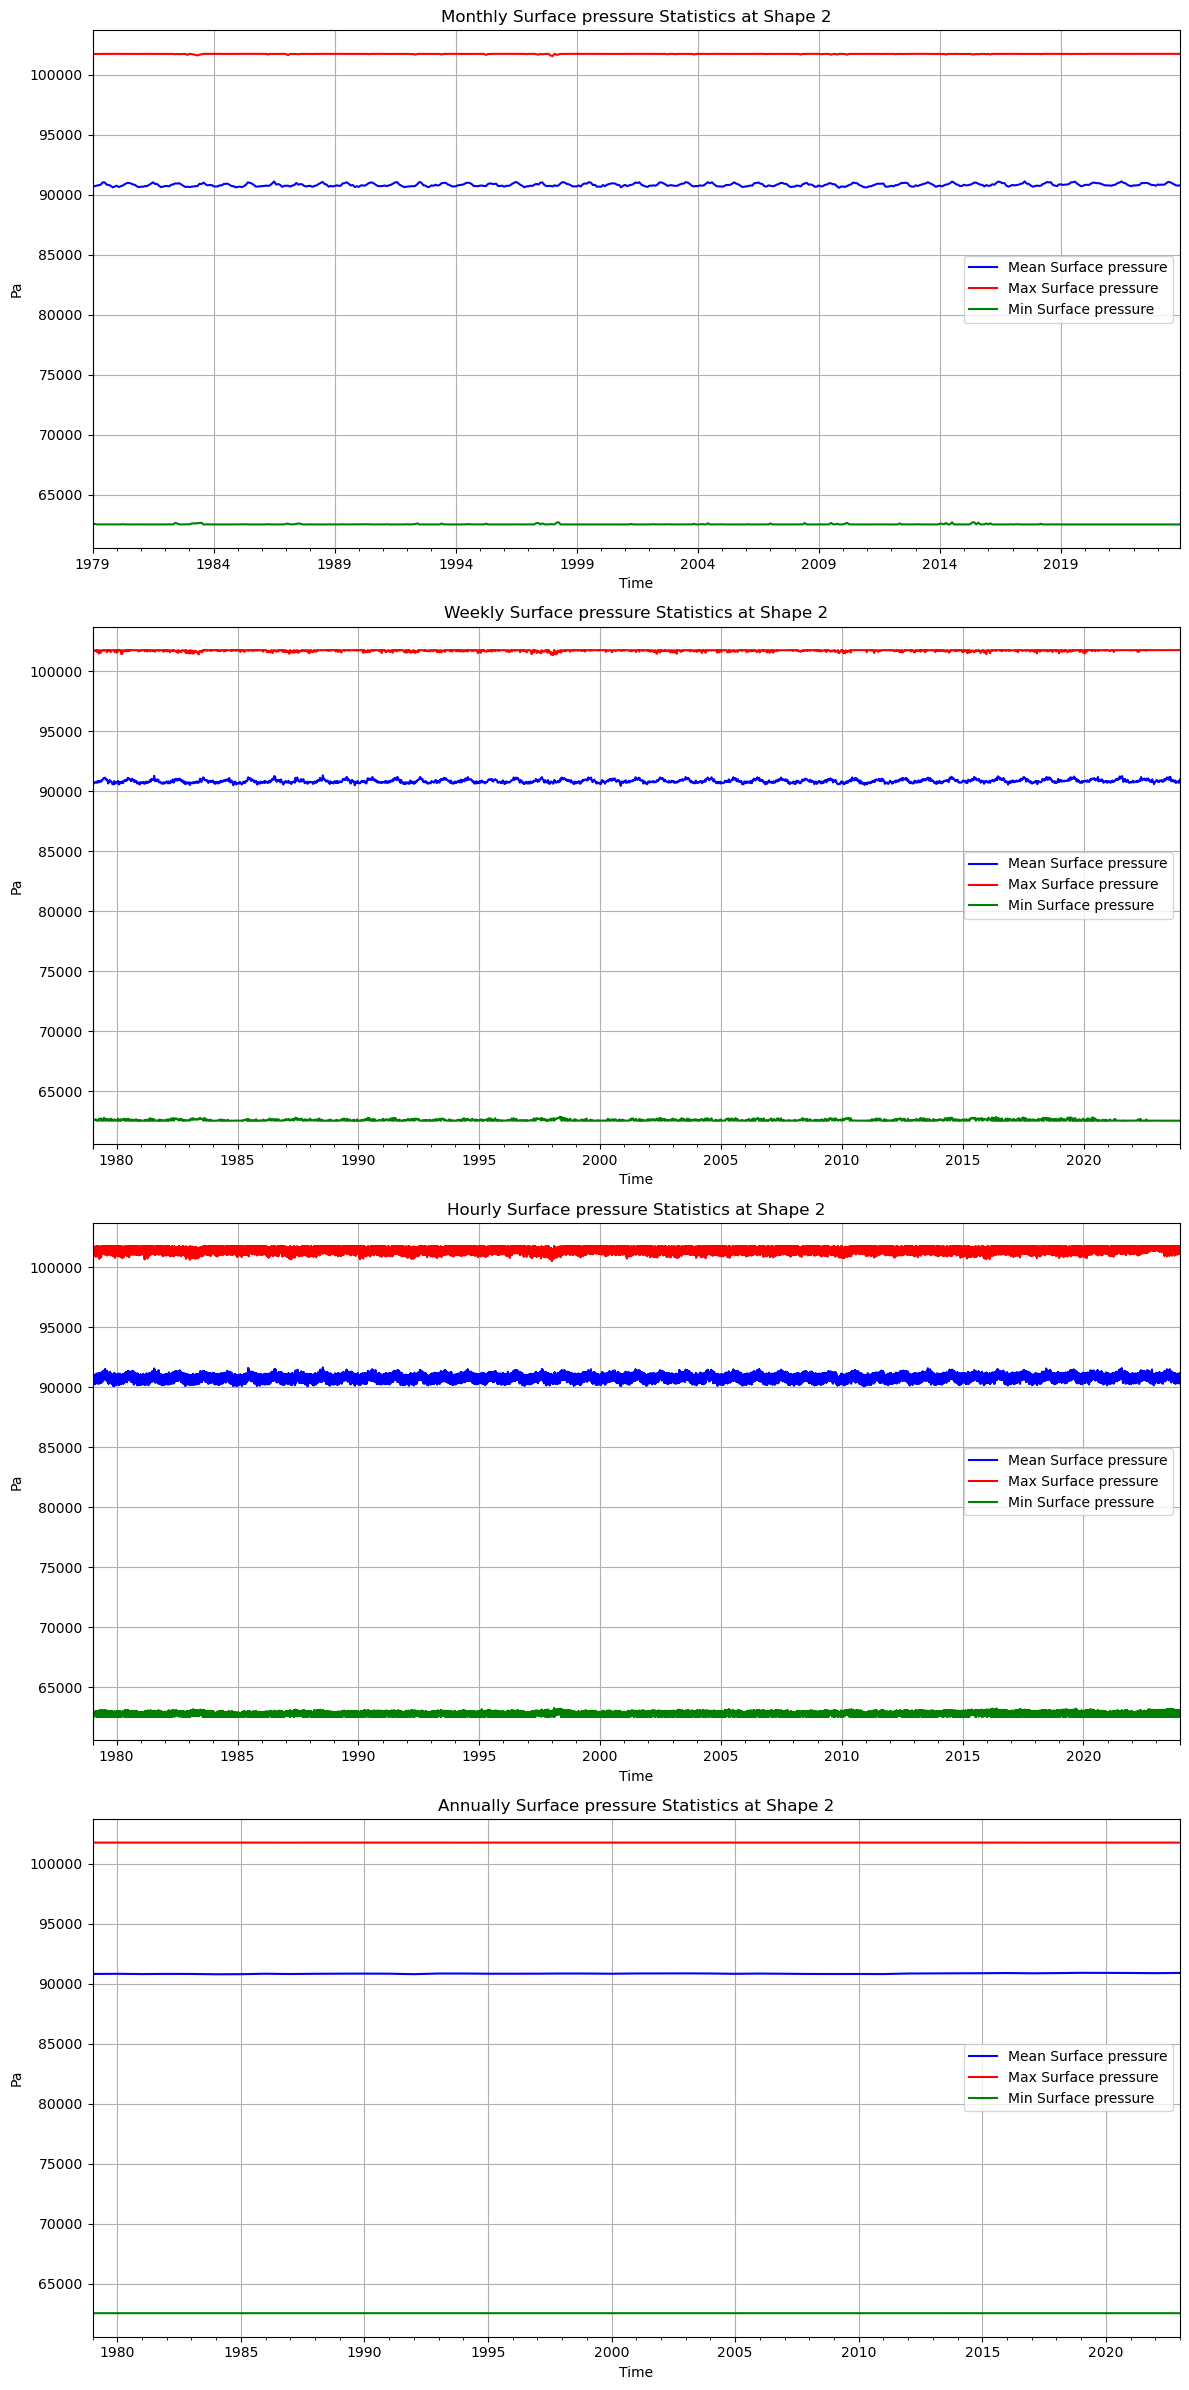

Monthly statistics saved to monthly_sp_statistics_shape_2.csv
Weekly statistics saved to weekly_sp_statistics_shape_2.csv
Hourly statistics saved to hourly_sp_statistics_shape_2.csv
Annually statistics saved to annually_sp_statistics_shape_2.csv


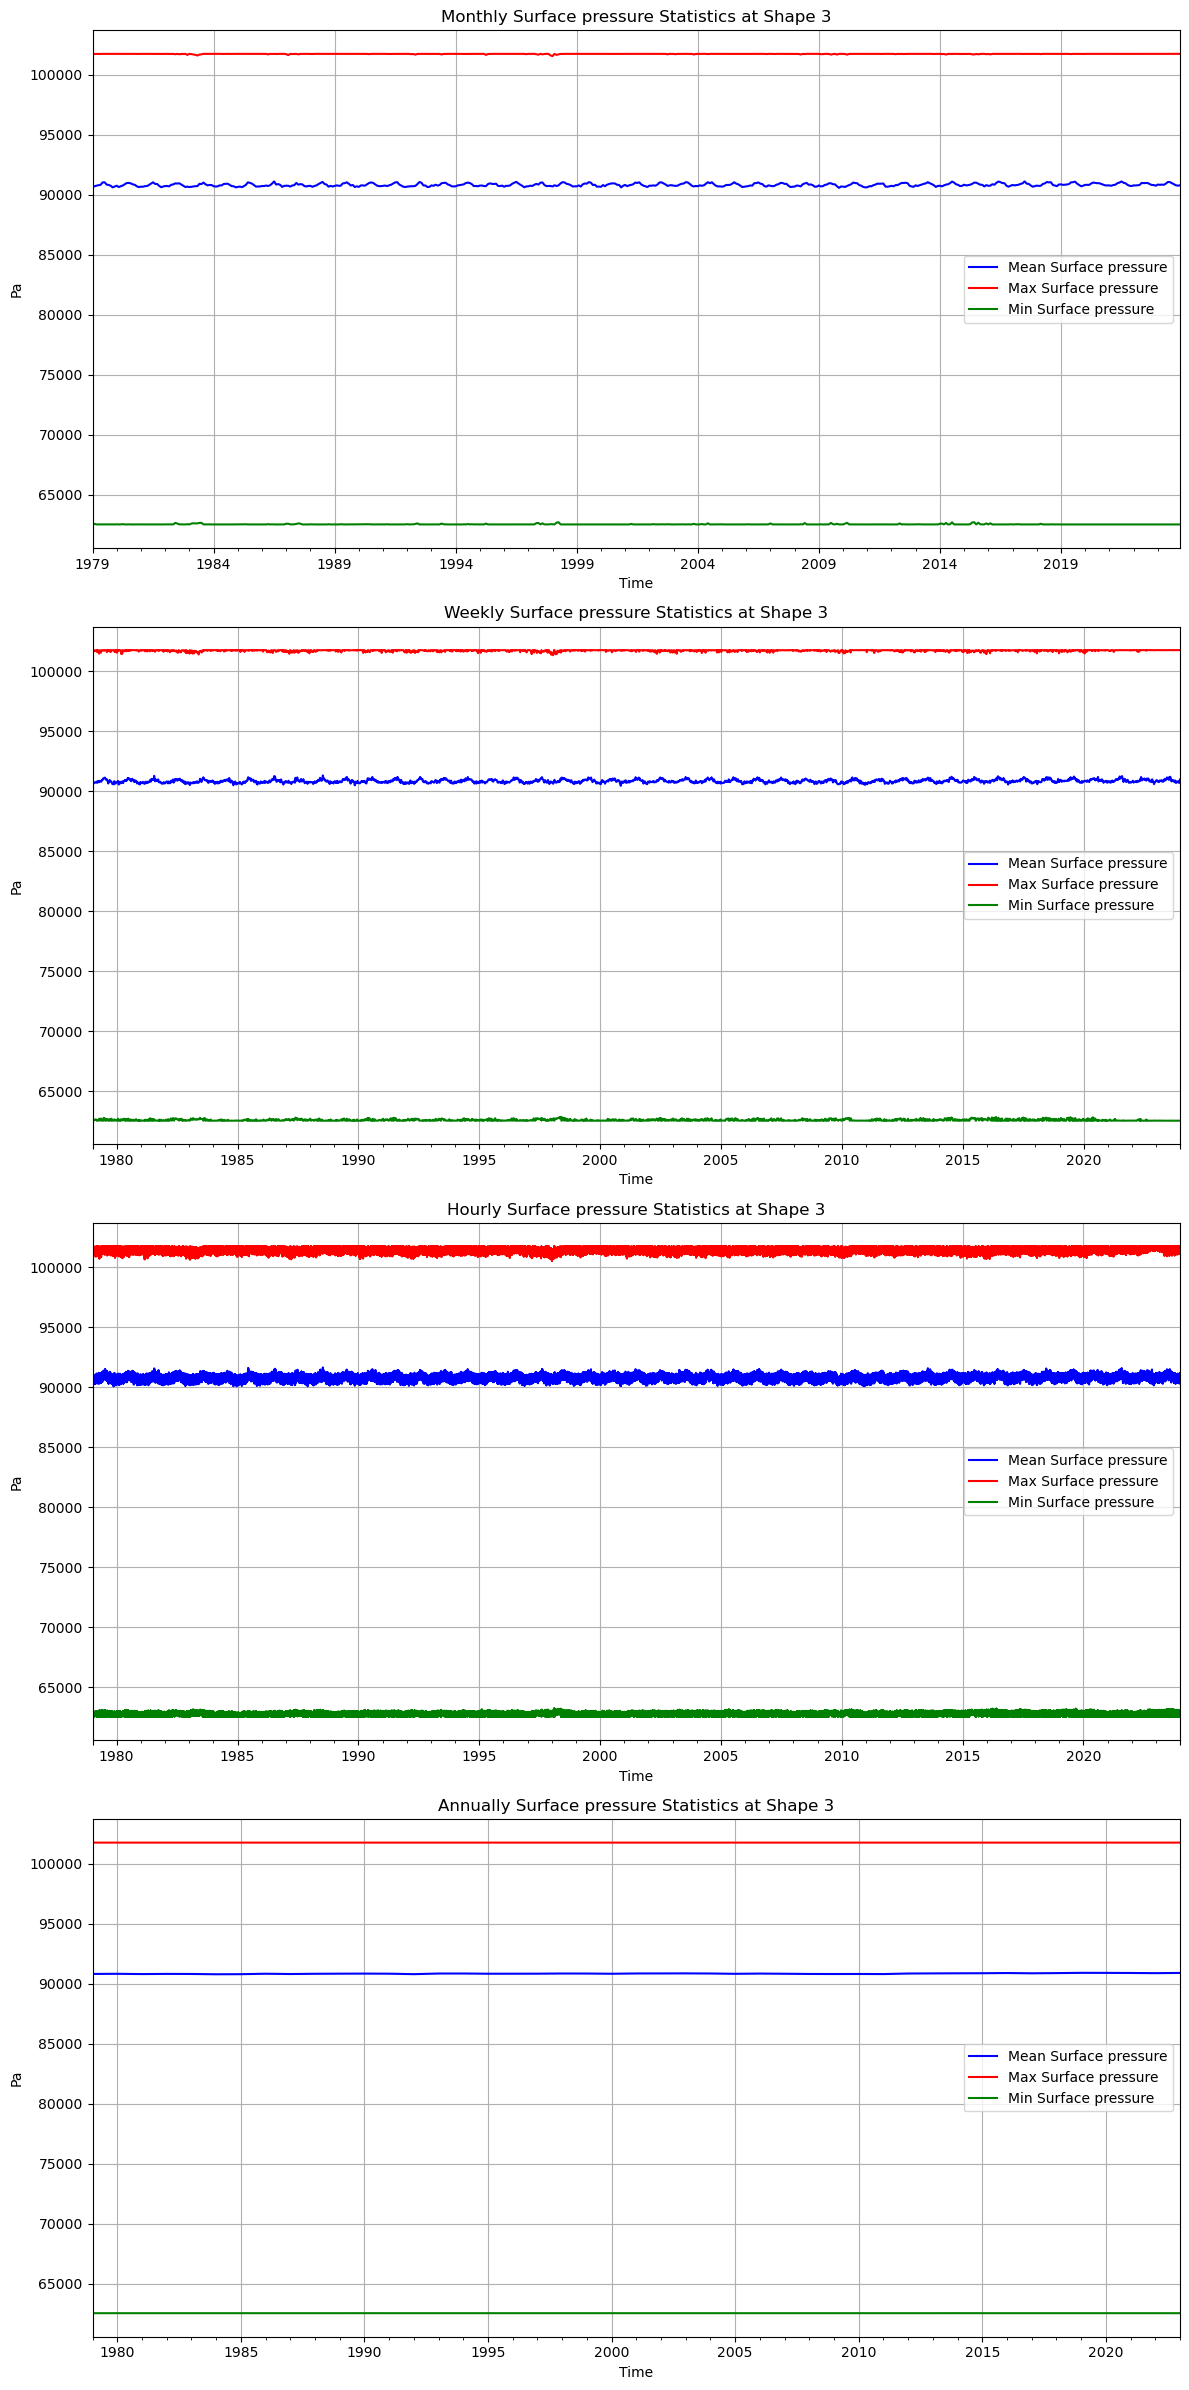

Monthly statistics saved to monthly_sp_statistics_shape_3.csv
Weekly statistics saved to weekly_sp_statistics_shape_3.csv
Hourly statistics saved to hourly_sp_statistics_shape_3.csv
Annually statistics saved to annually_sp_statistics_shape_3.csv


In [2]:
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import xarray as xr
import pandas as pd
from rasterstats import zonal_stats
import rioxarray as rio

def select_file(title, filetypes):
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title, filetypes=filetypes)
    return file_path

def select_variable(ds):
    variable_options = [f"{var} ({ds[var].attrs.get('long_name', 'No long name')})" for var in ds.variables]
    variable_selection = simpledialog.askstring("Input", f"Available variables:\n" + "\n".join(variable_options) + "\n\nPlease enter the variable name to use:")
    variable = variable_selection.split()[0]  # Extract the variable name
    return variable

def get_conversion(variable):
    kelvin_vars = ['d2m', 't2m', 'stl1', 'stl2', 'stl3', 'stl4', 'skt']
    meter_vars = ['tp', 'e', 'evabs', 'evaow', 'evatc', 'evavt', 'pev', 'ro', 'sro', 'src', 'ssro']

    if variable in kelvin_vars:
        conversion = simpledialog.askstring("Conversion", "Convert from Kelvins to:\n1. Celsius\n2. Fahrenheit")
        if conversion == '1':
            return lambda x: x - 273.15, 'Celsius'
        elif conversion == '2':
            return lambda x: (x - 273.15) * 9/5 + 32, 'Fahrenheit'
        else:
            return None, 'Kelvins'
    elif variable in meter_vars:
        conversion = simpledialog.askstring("Conversion", "Convert from Meters to:\n1. Millimeters\n2. Inches")
        if conversion == '1':
            return lambda x: x * 1000, 'Millimeters'
        elif conversion == '2':
            return lambda x: x * 39.3701, 'Inches'
        else:
            return None, 'Meters'
    else:
        return None, None

def load_and_plot_data_with_pcolormesh(shapefile_path, netcdf_path, variable):
    # Load the NetCDF data
    ds = xr.open_dataset(netcdf_path)
    
    # Select the specified variable
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the NetCDF file.")
    data = ds[variable]
    units = ds[variable].units
    # Get the long name of the variable
    long_name = data.attrs.get('long_name', variable)
    
    # For simplicity, select the first time step if the variable has a time dimension
    if 'time' in ds.dims:
        data = data.mean(dim='time')
    
    # Ensure the data is in 2D (latitude x longitude)
    assert data.ndim == 2, "Data must be 2D (latitude x longitude)."
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the NetCDF data using pcolormesh
    # Note: We assume the latitude and longitude are 1D arrays. Adjust as necessary.
    temperature = data.values
    lon = data.longitude.values
    lat = data.latitude.values
    mesh = ax.pcolormesh(lon, lat, temperature, shading='auto', cmap='viridis')
    fig.colorbar(mesh, ax=ax, label=long_name)
    
    # Load and plot the shapefile on top
    shp = gpd.read_file(shapefile_path)
    if shp.crs.to_string() != 'epsg:4326':
        shp = shp.to_crs(epsg=4326)
    shp.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
    
    # Add a basemap
    try:
        # Set the extent of the plot to the bounds of the shapefile
        minx, miny, maxx, maxy = shp.total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    except Exception as e:
        print(f"Contextily basemap could not be added. Error: {e}")

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{long_name} and Shapefile Overlay')
    plt.show()
    
    return shp, ds, long_name, data, units

def plot_and_save_statistics(shp, ds, variable, long_name, data, units, conversion_func=None, new_units=None):
    # Ensure original units are preserved if no conversion is applied
    original_units = units
    effective_units = new_units if new_units else original_units
    
    # Convert NetCDF data to DataArray and calculate zonal statistics
    for idx, geometry in enumerate(shp.geometry):
        zonal_stats_list = zonal_stats(geometry, data.values, stats=['mean', 'max', 'min'], affine=data.rio.transform())
        
        # Create a DataFrame from the zonal statistics
        stats_df = pd.DataFrame(zonal_stats_list)
        
        # Apply conversion if necessary
        if conversion_func:
            stats_df = stats_df.applymap(conversion_func)
        
        # Resample to different frequencies and calculate statistics
        ts = ds[variable]
        ts_df = ts.to_dataframe().reset_index()
        ts_df.set_index('time', inplace=True)
        
        resampled_stats = {
            'monthly': ts_df.resample('M').agg(['mean', 'max', 'min']),
            'weekly': ts_df.resample('W').agg(['mean', 'max', 'min']),
            'hourly': ts_df.resample('H').agg(['mean', 'max', 'min']),
            'annually': ts_df.resample('A').agg(['mean', 'max', 'min'])
        }
        
        # Plotting the statistics
        fig, axs = plt.subplots(4, 1, figsize=(12, 24))
        
        for ax, (freq, df) in zip(axs, resampled_stats.items()):
            df[variable]['mean'].plot(ax=ax, label=f'Mean {long_name}', color='blue')
            df[variable]['max'].plot(ax=ax, label=f'Max {long_name}', color='red')
            df[variable]['min'].plot(ax=ax, label=f'Min {long_name}', color='green')
            ax.set_title(f'{freq.capitalize()} {long_name} Statistics at Shape {idx + 1}')
            ax.set_xlabel('Time')
            ax.set_ylabel(effective_units)
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'statistics_{variable}_shape_{idx + 1}.png')
        plt.show()

        # Save the statistics to CSV files with units
        for freq, df in resampled_stats.items():
            df['units'] = effective_units
            csv_filename = f'{freq}_{variable}_statistics_shape_{idx + 1}.csv'
            df.to_csv(csv_filename)
            print(f"{freq.capitalize()} statistics saved to {csv_filename}")

# Example usage
shapefile_path = select_file("Select a Shapefile", [("Shapefiles", "*.shp")])
netcdf_path = select_file("Select a NetCDF File", [("NetCDF files", "*")])

if shapefile_path and netcdf_path:
    ds = xr.open_dataset(netcdf_path)
    variable = select_variable(ds)
    conversion_func, new_units = get_conversion(variable)
    shp, ds, long_name, data, units = load_and_plot_data_with_pcolormesh(shapefile_path, netcdf_path, variable)
    plot_and_save_statistics(shp, ds, variable, long_name, data, units, conversion_func, new_units)
else:
    print("Necessary files not selected.")
